##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows how to classify images of flowers. It creates an image classifier using a `keras.Sequential` model, and loads data using `preprocessing.image_dataset_from_directory`. You will gain practical experience with the following concepts:

* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and Dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

## Import TensorFlow and other libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains 5 sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

     8192/228813984 [..............................] - ETA: 2s

  5554176/228813984 [..............................] - ETA: 2s

  8396800/228813984 [>.............................] - ETA: 3s

 14041088/228813984 [>.............................] - ETA: 2s

 19660800/228813984 [=>............................] - ETA: 2s

 29949952/228813984 [==>...........................] - ETA: 1s



 45490176/228813984 [====>.........................] - ETA: 1s

 62726144/228813984 [=======>......................] - ETA: 0s

 75505664/228813984 [========>.....................] - ETA: 1s

 93249536/228813984 [===========>..................] - ETA: 0s

111288320/228813984 [=============>................] - ETA: 0s

117448704/228813984 [==============>...............] - ETA: 0s

135266304/228813984 [================>.............] - ETA: 0s

152256512/228813984 [==================>...........] - ETA: 0s

161153024/228813984 [====================>.........] - ETA: 0s

167780352/228813984 [====================>.........] - ETA: 0s

184188928/228813984 [=======================>......] - ETA: 0s

201334784/228813984 [=========================>....] - ETA: 0s

219299840/228813984 [===========================>..] - ETA: 0s

228818944/228813984 [==============================] - 2s 0us/step


After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Here are some roses:

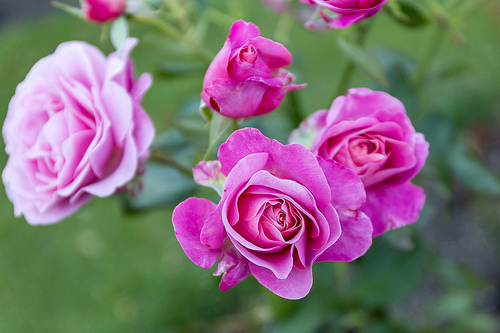

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

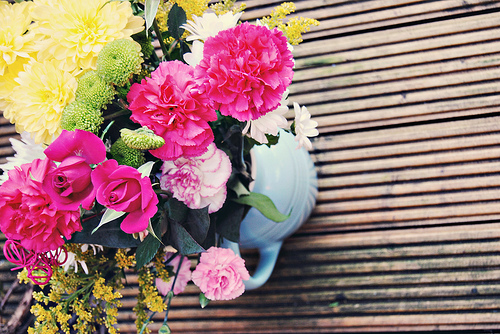

In [6]:
PIL.Image.open(str(roses[1]))

And some tulips:

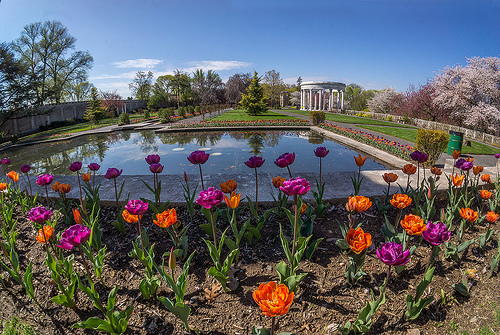

In [7]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

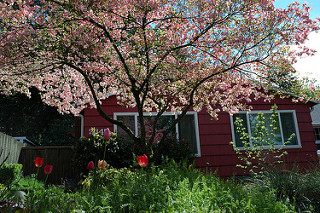

In [8]:
PIL.Image.open(str(tulips[1]))

# Load using keras.preprocessing

Let's load these images off disk using the helpful [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [load images](https://www.tensorflow.org/tutorials/load_data/images) tutorial.

## Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [12]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

Here are the first 9 images from the training dataset.

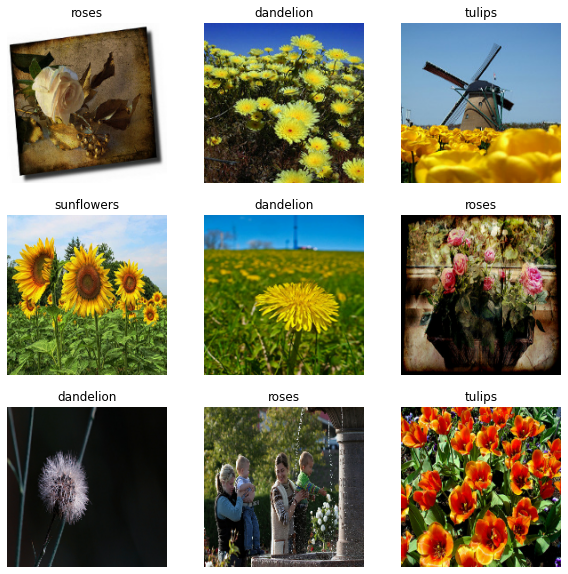

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will train a model using these datasets by passing them to `model.fit` in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images. 

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training. 

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the `[0, 1]` range by using a Rescaling layer.

In [16]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

Note: The Keras Preprocessing utilities and layers introduced in this section are currently experimental and may change.

There are two ways to use this layer. You can apply it to the dataset by calling map:

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.9407408


Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

Note: you previously resized images using the `image_size` argument of `image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the [Resizing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer.

# Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function. This model has not been tuned for high accuracy, the goal of this tutorial is to show a standard approach. 

In [18]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model

For this tutorial, choose the `optimizers.Adam` optimizer and `losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

View all the layers of the network using the model's `summary` method:

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

## Train the model

In [21]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


 1/92 [..............................] - ETA: 3:28 - loss: 1.5983 - accuracy: 0.2812

 7/92 [=>............................] - ETA: 0s - loss: 2.4127 - accuracy: 0.2480  

13/92 [===>..........................] - ETA: 0s - loss: 2.2248 - accuracy: 0.2461

19/92 [=====>........................] - ETA: 0s - loss: 2.1068 - accuracy: 0.2453

25/92 [=======>......................] - ETA: 0s - loss: 2.0270 - accuracy: 0.2476

31/92 [=========>....................] - ETA: 0s - loss: 1.9692 - accuracy: 0.2501

37/92 [===========>..................] - ETA: 0s - loss: 1.9246 - accuracy: 0.2541

43/92 [=============>................] - ETA: 0s - loss: 1.8881 - accuracy: 0.2589

49/92 [==============>...............] - ETA: 0s - loss: 1.8573 - accuracy: 0.2633

54/92 [================>.............] - ETA: 0s - loss: 1.8349 - accuracy: 0.2672

60/92 [==================>...........] - ETA: 0s - loss: 1.8116 - accuracy: 0.2718

66/92 [====================>.........] - ETA: 0s - loss: 1.7906 - accuracy: 0.2764

72/92 [======================>.......] - ETA: 0s - loss: 1.7710 - accuracy: 0.2810

78/92 [========================>.....] - ETA: 0s - loss: 1.7524 - accuracy: 0.2858

84/92 [==========================>...] - ETA: 0s - loss: 1.7350 - accuracy: 0.2905

90/92 [============================>.] - ETA: 0s - loss: 1.7183 - accuracy: 0.2953

92/92 [==============================] - 5s 27ms/step - loss: 1.7103 - accuracy: 0.2977 - val_loss: 1.2054 - val_accuracy: 0.4986


Epoch 2/10
 1/92 [..............................] - ETA: 0s - loss: 1.1557 - accuracy: 0.4688

 7/92 [=>............................] - ETA: 0s - loss: 1.1071 - accuracy: 0.5345

13/92 [===>..........................] - ETA: 0s - loss: 1.1162 - accuracy: 0.5328

19/92 [=====>........................] - ETA: 0s - loss: 1.1167 - accuracy: 0.5341

25/92 [=======>......................] - ETA: 0s - loss: 1.1163 - accuracy: 0.5339

31/92 [=========>....................] - ETA: 0s - loss: 1.1158 - accuracy: 0.5345

37/92 [===========>..................] - ETA: 0s - loss: 1.1123 - accuracy: 0.5370

43/92 [=============>................] - ETA: 0s - loss: 1.1078 - accuracy: 0.5406

49/92 [==============>...............] - ETA: 0s - loss: 1.1039 - accuracy: 0.5437

55/92 [================>.............] - ETA: 0s - loss: 1.1022 - accuracy: 0.5457

61/92 [==================>...........] - ETA: 0s - loss: 1.1019 - accuracy: 0.5471

67/92 [====================>.........] - ETA: 0s - loss: 1.1012 - accuracy: 0.5485

73/92 [======================>.......] - ETA: 0s - loss: 1.1004 - accuracy: 0.5500

79/92 [========================>.....] - ETA: 0s - loss: 1.0992 - accuracy: 0.5514

85/92 [==========================>...] - ETA: 0s - loss: 1.0979 - accuracy: 0.5527

91/92 [============================>.] - ETA: 0s - loss: 1.0964 - accuracy: 0.5540

92/92 [==============================] - 1s 11ms/step - loss: 1.0959 - accuracy: 0.5544 - val_loss: 1.0688 - val_accuracy: 0.5763


Epoch 3/10
 1/92 [..............................] - ETA: 0s - loss: 1.1127 - accuracy: 0.6250

 7/92 [=>............................] - ETA: 0s - loss: 1.0135 - accuracy: 0.6223

13/92 [===>..........................] - ETA: 0s - loss: 0.9837 - accuracy: 0.6246

19/92 [=====>........................] - ETA: 0s - loss: 0.9740 - accuracy: 0.6236

25/92 [=======>......................] - ETA: 0s - loss: 0.9652 - accuracy: 0.6242

31/92 [=========>....................] - ETA: 0s - loss: 0.9604 - accuracy: 0.6250

37/92 [===========>..................] - ETA: 0s - loss: 0.9554 - accuracy: 0.6262

43/92 [=============>................] - ETA: 0s - loss: 0.9522 - accuracy: 0.6268

49/92 [==============>...............] - ETA: 0s - loss: 0.9487 - accuracy: 0.6276

55/92 [================>.............] - ETA: 0s - loss: 0.9461 - accuracy: 0.6283

61/92 [==================>...........] - ETA: 0s - loss: 0.9438 - accuracy: 0.6289

67/92 [====================>.........] - ETA: 0s - loss: 0.9413 - accuracy: 0.6295

73/92 [======================>.......] - ETA: 0s - loss: 0.9386 - accuracy: 0.6305

79/92 [========================>.....] - ETA: 0s - loss: 0.9365 - accuracy: 0.6314

85/92 [==========================>...] - ETA: 0s - loss: 0.9348 - accuracy: 0.6321

91/92 [============================>.] - ETA: 0s - loss: 0.9334 - accuracy: 0.6327

92/92 [==============================] - 1s 11ms/step - loss: 0.9331 - accuracy: 0.6329 - val_loss: 0.9369 - val_accuracy: 0.6267


Epoch 4/10
 1/92 [..............................] - ETA: 0s - loss: 0.8329 - accuracy: 0.6562

 7/92 [=>............................] - ETA: 0s - loss: 0.8677 - accuracy: 0.6792

13/92 [===>..........................] - ETA: 0s - loss: 0.8499 - accuracy: 0.6900

19/92 [=====>........................] - ETA: 0s - loss: 0.8375 - accuracy: 0.6914

25/92 [=======>......................] - ETA: 0s - loss: 0.8334 - accuracy: 0.6901

31/92 [=========>....................] - ETA: 0s - loss: 0.8312 - accuracy: 0.6885

37/92 [===========>..................] - ETA: 0s - loss: 0.8279 - accuracy: 0.6885

43/92 [=============>................] - ETA: 0s - loss: 0.8258 - accuracy: 0.6891

49/92 [==============>...............] - ETA: 0s - loss: 0.8253 - accuracy: 0.6892

55/92 [================>.............] - ETA: 0s - loss: 0.8243 - accuracy: 0.6894

61/92 [==================>...........] - ETA: 0s - loss: 0.8221 - accuracy: 0.6902

67/92 [====================>.........] - ETA: 0s - loss: 0.8192 - accuracy: 0.6913

73/92 [======================>.......] - ETA: 0s - loss: 0.8161 - accuracy: 0.6922

79/92 [========================>.....] - ETA: 0s - loss: 0.8132 - accuracy: 0.6930

85/92 [==========================>...] - ETA: 0s - loss: 0.8103 - accuracy: 0.6938

91/92 [============================>.] - ETA: 0s - loss: 0.8073 - accuracy: 0.6948

92/92 [==============================] - 1s 11ms/step - loss: 0.8064 - accuracy: 0.6951 - val_loss: 0.9546 - val_accuracy: 0.6335


Epoch 5/10
 1/92 [..............................] - ETA: 0s - loss: 0.5219 - accuracy: 0.8750

 7/92 [=>............................] - ETA: 0s - loss: 0.5939 - accuracy: 0.8040

13/92 [===>..........................] - ETA: 0s - loss: 0.5881 - accuracy: 0.7973

19/92 [=====>........................] - ETA: 0s - loss: 0.5769 - accuracy: 0.7986

25/92 [=======>......................] - ETA: 0s - loss: 0.5676 - accuracy: 0.7999

31/92 [=========>....................] - ETA: 0s - loss: 0.5613 - accuracy: 0.8009

37/92 [===========>..................] - ETA: 0s - loss: 0.5545 - accuracy: 0.8031

43/92 [=============>................] - ETA: 0s - loss: 0.5515 - accuracy: 0.8040

49/92 [==============>...............] - ETA: 0s - loss: 0.5513 - accuracy: 0.8032

55/92 [================>.............] - ETA: 0s - loss: 0.5526 - accuracy: 0.8018

61/92 [==================>...........] - ETA: 0s - loss: 0.5541 - accuracy: 0.8006

67/92 [====================>.........] - ETA: 0s - loss: 0.5563 - accuracy: 0.7991

73/92 [======================>.......] - ETA: 0s - loss: 0.5585 - accuracy: 0.7974

79/92 [========================>.....] - ETA: 0s - loss: 0.5606 - accuracy: 0.7959

85/92 [==========================>...] - ETA: 0s - loss: 0.5624 - accuracy: 0.7947

91/92 [============================>.] - ETA: 0s - loss: 0.5639 - accuracy: 0.7936

92/92 [==============================] - 1s 11ms/step - loss: 0.5643 - accuracy: 0.7933 - val_loss: 0.9191 - val_accuracy: 0.6444


Epoch 6/10
 1/92 [..............................] - ETA: 0s - loss: 0.4209 - accuracy: 0.8750

 7/92 [=>............................] - ETA: 0s - loss: 0.4180 - accuracy: 0.8707

13/92 [===>..........................] - ETA: 0s - loss: 0.4142 - accuracy: 0.8675

19/92 [=====>........................] - ETA: 0s - loss: 0.4059 - accuracy: 0.8709

25/92 [=======>......................] - ETA: 0s - loss: 0.4018 - accuracy: 0.8735

31/92 [=========>....................] - ETA: 0s - loss: 0.4001 - accuracy: 0.8745

37/92 [===========>..................] - ETA: 0s - loss: 0.3987 - accuracy: 0.8744

43/92 [=============>................] - ETA: 0s - loss: 0.3978 - accuracy: 0.8738

49/92 [==============>...............] - ETA: 0s - loss: 0.3962 - accuracy: 0.8735

55/92 [================>.............] - ETA: 0s - loss: 0.3945 - accuracy: 0.8734

61/92 [==================>...........] - ETA: 0s - loss: 0.3937 - accuracy: 0.8732

67/92 [====================>.........] - ETA: 0s - loss: 0.3927 - accuracy: 0.8732

73/92 [======================>.......] - ETA: 0s - loss: 0.3918 - accuracy: 0.8731

79/92 [========================>.....] - ETA: 0s - loss: 0.3912 - accuracy: 0.8728

85/92 [==========================>...] - ETA: 0s - loss: 0.3910 - accuracy: 0.8724

91/92 [============================>.] - ETA: 0s - loss: 0.3910 - accuracy: 0.8719

92/92 [==============================] - 1s 11ms/step - loss: 0.3910 - accuracy: 0.8717 - val_loss: 1.2451 - val_accuracy: 0.5954


Epoch 7/10
 1/92 [..............................] - ETA: 0s - loss: 0.4212 - accuracy: 0.8125

 7/92 [=>............................] - ETA: 0s - loss: 0.3626 - accuracy: 0.8701

13/92 [===>..........................] - ETA: 0s - loss: 0.3487 - accuracy: 0.8812

19/92 [=====>........................] - ETA: 0s - loss: 0.3359 - accuracy: 0.8884

25/92 [=======>......................] - ETA: 0s - loss: 0.3223 - accuracy: 0.8949

31/92 [=========>....................] - ETA: 0s - loss: 0.3118 - accuracy: 0.8996

37/92 [===========>..................] - ETA: 0s - loss: 0.3057 - accuracy: 0.9022

43/92 [=============>................] - ETA: 0s - loss: 0.3005 - accuracy: 0.9040

49/92 [==============>...............] - ETA: 0s - loss: 0.2963 - accuracy: 0.9056

55/92 [================>.............] - ETA: 0s - loss: 0.2935 - accuracy: 0.9065

61/92 [==================>...........] - ETA: 0s - loss: 0.2914 - accuracy: 0.9072

67/92 [====================>.........] - ETA: 0s - loss: 0.2897 - accuracy: 0.9078

73/92 [======================>.......] - ETA: 0s - loss: 0.2880 - accuracy: 0.9084

79/92 [========================>.....] - ETA: 0s - loss: 0.2868 - accuracy: 0.9088

85/92 [==========================>...] - ETA: 0s - loss: 0.2859 - accuracy: 0.9091

91/92 [============================>.] - ETA: 0s - loss: 0.2851 - accuracy: 0.9094

92/92 [==============================] - 1s 11ms/step - loss: 0.2849 - accuracy: 0.9094 - val_loss: 1.2454 - val_accuracy: 0.6335


Epoch 8/10
 1/92 [..............................] - ETA: 0s - loss: 0.1420 - accuracy: 0.9688

 7/92 [=>............................] - ETA: 0s - loss: 0.2035 - accuracy: 0.9432

13/92 [===>..........................] - ETA: 0s - loss: 0.1912 - accuracy: 0.9457

19/92 [=====>........................] - ETA: 0s - loss: 0.1835 - accuracy: 0.9480

25/92 [=======>......................] - ETA: 0s - loss: 0.1774 - accuracy: 0.9502

31/92 [=========>....................] - ETA: 0s - loss: 0.1726 - accuracy: 0.9523

37/92 [===========>..................] - ETA: 0s - loss: 0.1676 - accuracy: 0.9542

43/92 [=============>................] - ETA: 0s - loss: 0.1640 - accuracy: 0.9554

49/92 [==============>...............] - ETA: 0s - loss: 0.1617 - accuracy: 0.9562

55/92 [================>.............] - ETA: 0s - loss: 0.1603 - accuracy: 0.9566

61/92 [==================>...........] - ETA: 0s - loss: 0.1591 - accuracy: 0.9569

67/92 [====================>.........] - ETA: 0s - loss: 0.1580 - accuracy: 0.9571

73/92 [======================>.......] - ETA: 0s - loss: 0.1573 - accuracy: 0.9571

79/92 [========================>.....] - ETA: 0s - loss: 0.1567 - accuracy: 0.9570

85/92 [==========================>...] - ETA: 0s - loss: 0.1563 - accuracy: 0.9569

91/92 [============================>.] - ETA: 0s - loss: 0.1562 - accuracy: 0.9568

92/92 [==============================] - 1s 11ms/step - loss: 0.1562 - accuracy: 0.9567 - val_loss: 1.2909 - val_accuracy: 0.6322


Epoch 9/10
 1/92 [..............................] - ETA: 0s - loss: 0.0983 - accuracy: 0.9688

 7/92 [=>............................] - ETA: 0s - loss: 0.0824 - accuracy: 0.9739

13/92 [===>..........................] - ETA: 0s - loss: 0.1046 - accuracy: 0.9636

19/92 [=====>........................] - ETA: 0s - loss: 0.1115 - accuracy: 0.9614

25/92 [=======>......................] - ETA: 0s - loss: 0.1120 - accuracy: 0.9614

31/92 [=========>....................] - ETA: 0s - loss: 0.1119 - accuracy: 0.9616

37/92 [===========>..................] - ETA: 0s - loss: 0.1118 - accuracy: 0.9622

43/92 [=============>................] - ETA: 0s - loss: 0.1129 - accuracy: 0.9623

49/92 [==============>...............] - ETA: 0s - loss: 0.1141 - accuracy: 0.9624

55/92 [================>.............] - ETA: 0s - loss: 0.1154 - accuracy: 0.9620

61/92 [==================>...........] - ETA: 0s - loss: 0.1162 - accuracy: 0.9618

67/92 [====================>.........] - ETA: 0s - loss: 0.1165 - accuracy: 0.9617

73/92 [======================>.......] - ETA: 0s - loss: 0.1164 - accuracy: 0.9618

79/92 [========================>.....] - ETA: 0s - loss: 0.1162 - accuracy: 0.9619

85/92 [==========================>...] - ETA: 0s - loss: 0.1159 - accuracy: 0.9620

91/92 [============================>.] - ETA: 0s - loss: 0.1156 - accuracy: 0.9622

92/92 [==============================] - 1s 11ms/step - loss: 0.1154 - accuracy: 0.9622 - val_loss: 1.4424 - val_accuracy: 0.6322


Epoch 10/10
 1/92 [..............................] - ETA: 0s - loss: 0.0349 - accuracy: 1.0000

 7/92 [=>............................] - ETA: 0s - loss: 0.0604 - accuracy: 0.9906

13/92 [===>..........................] - ETA: 0s - loss: 0.0605 - accuracy: 0.9921

19/92 [=====>........................] - ETA: 0s - loss: 0.0583 - accuracy: 0.9924

25/92 [=======>......................] - ETA: 0s - loss: 0.0567 - accuracy: 0.9923

31/92 [=========>....................] - ETA: 0s - loss: 0.0559 - accuracy: 0.9917

37/92 [===========>..................] - ETA: 0s - loss: 0.0555 - accuracy: 0.9913

43/92 [=============>................] - ETA: 0s - loss: 0.0568 - accuracy: 0.9907

49/92 [==============>...............] - ETA: 0s - loss: 0.0586 - accuracy: 0.9899

55/92 [================>.............] - ETA: 0s - loss: 0.0606 - accuracy: 0.9890

61/92 [==================>...........] - ETA: 0s - loss: 0.0620 - accuracy: 0.9882

67/92 [====================>.........] - ETA: 0s - loss: 0.0630 - accuracy: 0.9878

73/92 [======================>.......] - ETA: 0s - loss: 0.0637 - accuracy: 0.9874

79/92 [========================>.....] - ETA: 0s - loss: 0.0643 - accuracy: 0.9871

85/92 [==========================>...] - ETA: 0s - loss: 0.0646 - accuracy: 0.9869

91/92 [============================>.] - ETA: 0s - loss: 0.0648 - accuracy: 0.9867

92/92 [==============================] - 1s 11ms/step - loss: 0.0649 - accuracy: 0.9866 - val_loss: 1.6675 - val_accuracy: 0.6308


## Visualize training results

Create plots of loss and accuracy on the training and validation sets.

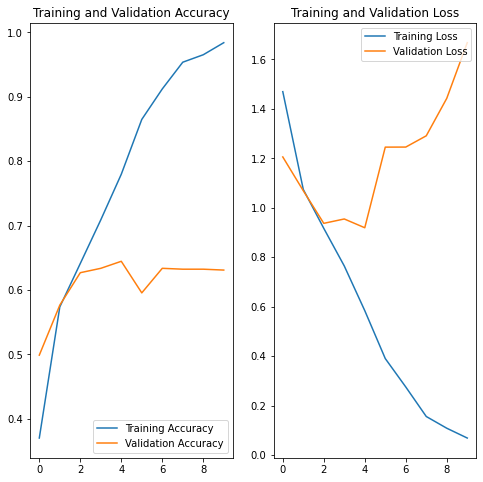

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As you can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around 60% accuracy on the validation set.

Let's look at what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *Dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the layers from `tf.keras.layers.experimental.preprocessing`. These can be included inside your model like other layers, and run on the GPU.

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

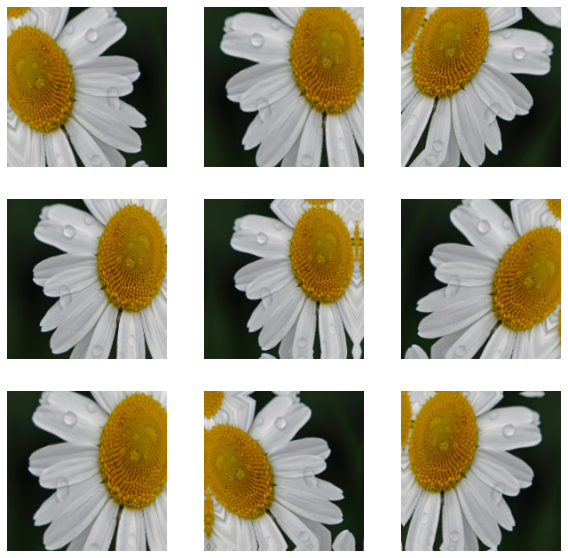

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will use data augmentation to train a model in a moment.

## Dropout

Another technique to reduce overfitting is to introduce [Dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) to the network, a form of *regularization*.

When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network using `layers.Dropout`, then train it using augmented images.

In [25]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [28]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


 1/92 [..............................] - ETA: 53s - loss: 1.6156 - accuracy: 0.1562

 7/92 [=>............................] - ETA: 0s - loss: 1.9299 - accuracy: 0.2292 

13/92 [===>..........................] - ETA: 0s - loss: 1.8645 - accuracy: 0.2307

19/92 [=====>........................] - ETA: 0s - loss: 1.8129 - accuracy: 0.2353

25/92 [=======>......................] - ETA: 0s - loss: 1.7724 - accuracy: 0.2454

31/92 [=========>....................] - ETA: 0s - loss: 1.7404 - accuracy: 0.2540

37/92 [===========>..................] - ETA: 0s - loss: 1.7130 - accuracy: 0.2629

43/92 [=============>................] - ETA: 0s - loss: 1.6870 - accuracy: 0.2734

49/92 [==============>...............] - ETA: 0s - loss: 1.6636 - accuracy: 0.2831

55/92 [================>.............] - ETA: 0s - loss: 1.6427 - accuracy: 0.2923

61/92 [==================>...........] - ETA: 0s - loss: 1.6226 - accuracy: 0.3012

67/92 [====================>.........] - ETA: 0s - loss: 1.6043 - accuracy: 0.3094

73/92 [======================>.......] - ETA: 0s - loss: 1.5880 - accuracy: 0.3170

79/92 [========================>.....] - ETA: 0s - loss: 1.5727 - accuracy: 0.3241

85/92 [==========================>...] - ETA: 0s - loss: 1.5583 - accuracy: 0.3311

91/92 [============================>.] - ETA: 0s - loss: 1.5444 - accuracy: 0.3379

92/92 [==============================] - 2s 13ms/step - loss: 1.5399 - accuracy: 0.3400 - val_loss: 1.2366 - val_accuracy: 0.4986


Epoch 2/15
 1/92 [..............................] - ETA: 0s - loss: 1.1256 - accuracy: 0.5938

 7/92 [=>............................] - ETA: 0s - loss: 1.0282 - accuracy: 0.5901

13/92 [===>..........................] - ETA: 0s - loss: 1.0367 - accuracy: 0.5938

19/92 [=====>........................] - ETA: 0s - loss: 1.0410 - accuracy: 0.5962

25/92 [=======>......................] - ETA: 0s - loss: 1.0447 - accuracy: 0.5933

31/92 [=========>....................] - ETA: 0s - loss: 1.0467 - accuracy: 0.5908

37/92 [===========>..................] - ETA: 0s - loss: 1.0483 - accuracy: 0.5879

43/92 [=============>................] - ETA: 0s - loss: 1.0484 - accuracy: 0.5862

49/92 [==============>...............] - ETA: 0s - loss: 1.0477 - accuracy: 0.5858

55/92 [================>.............] - ETA: 0s - loss: 1.0468 - accuracy: 0.5861

61/92 [==================>...........] - ETA: 0s - loss: 1.0454 - accuracy: 0.5866

67/92 [====================>.........] - ETA: 0s - loss: 1.0438 - accuracy: 0.5872

73/92 [======================>.......] - ETA: 0s - loss: 1.0428 - accuracy: 0.5877

79/92 [========================>.....] - ETA: 0s - loss: 1.0415 - accuracy: 0.5883

85/92 [==========================>...] - ETA: 0s - loss: 1.0399 - accuracy: 0.5890

91/92 [============================>.] - ETA: 0s - loss: 1.0386 - accuracy: 0.5898

92/92 [==============================] - 1s 11ms/step - loss: 1.0382 - accuracy: 0.5900 - val_loss: 0.9774 - val_accuracy: 0.6090


Epoch 3/15
 1/92 [..............................] - ETA: 0s - loss: 0.8202 - accuracy: 0.7812

 7/92 [=>............................] - ETA: 0s - loss: 0.8818 - accuracy: 0.7046

13/92 [===>..........................] - ETA: 0s - loss: 0.8945 - accuracy: 0.6849

19/92 [=====>........................] - ETA: 0s - loss: 0.9028 - accuracy: 0.6743

25/92 [=======>......................] - ETA: 0s - loss: 0.9098 - accuracy: 0.6672

31/92 [=========>....................] - ETA: 0s - loss: 0.9160 - accuracy: 0.6618

37/92 [===========>..................] - ETA: 0s - loss: 0.9191 - accuracy: 0.6585

43/92 [=============>................] - ETA: 0s - loss: 0.9223 - accuracy: 0.6555

49/92 [==============>...............] - ETA: 0s - loss: 0.9257 - accuracy: 0.6534

55/92 [================>.............] - ETA: 0s - loss: 0.9282 - accuracy: 0.6522

61/92 [==================>...........] - ETA: 0s - loss: 0.9304 - accuracy: 0.6510

67/92 [====================>.........] - ETA: 0s - loss: 0.9322 - accuracy: 0.6499

73/92 [======================>.......] - ETA: 0s - loss: 0.9337 - accuracy: 0.6489

79/92 [========================>.....] - ETA: 0s - loss: 0.9343 - accuracy: 0.6483

85/92 [==========================>...] - ETA: 0s - loss: 0.9345 - accuracy: 0.6478

91/92 [============================>.] - ETA: 0s - loss: 0.9348 - accuracy: 0.6473

92/92 [==============================] - 1s 11ms/step - loss: 0.9348 - accuracy: 0.6472 - val_loss: 0.9294 - val_accuracy: 0.6362


Epoch 4/15
 1/92 [..............................] - ETA: 0s - loss: 1.0403 - accuracy: 0.5938

 7/92 [=>............................] - ETA: 0s - loss: 1.0332 - accuracy: 0.5944

13/92 [===>..........................] - ETA: 0s - loss: 0.9881 - accuracy: 0.6109

19/92 [=====>........................] - ETA: 0s - loss: 0.9592 - accuracy: 0.6199

25/92 [=======>......................] - ETA: 0s - loss: 0.9397 - accuracy: 0.6273

31/92 [=========>....................] - ETA: 0s - loss: 0.9279 - accuracy: 0.6317

37/92 [===========>..................] - ETA: 0s - loss: 0.9198 - accuracy: 0.6350

43/92 [=============>................] - ETA: 0s - loss: 0.9141 - accuracy: 0.6370

49/92 [==============>...............] - ETA: 0s - loss: 0.9084 - accuracy: 0.6396

55/92 [================>.............] - ETA: 0s - loss: 0.9042 - accuracy: 0.6417

61/92 [==================>...........] - ETA: 0s - loss: 0.9009 - accuracy: 0.6430

67/92 [====================>.........] - ETA: 0s - loss: 0.8983 - accuracy: 0.6441

73/92 [======================>.......] - ETA: 0s - loss: 0.8960 - accuracy: 0.6451

79/92 [========================>.....] - ETA: 0s - loss: 0.8936 - accuracy: 0.6463

85/92 [==========================>...] - ETA: 0s - loss: 0.8914 - accuracy: 0.6474

91/92 [============================>.] - ETA: 0s - loss: 0.8896 - accuracy: 0.6483

92/92 [==============================] - 1s 11ms/step - loss: 0.8891 - accuracy: 0.6486 - val_loss: 0.9018 - val_accuracy: 0.6621


Epoch 5/15
 1/92 [..............................] - ETA: 0s - loss: 0.8973 - accuracy: 0.5625

 7/92 [=>............................] - ETA: 0s - loss: 0.8147 - accuracy: 0.6600

13/92 [===>..........................] - ETA: 0s - loss: 0.8403 - accuracy: 0.6616

19/92 [=====>........................] - ETA: 0s - loss: 0.8543 - accuracy: 0.6609

25/92 [=======>......................] - ETA: 0s - loss: 0.8569 - accuracy: 0.6622

31/92 [=========>....................] - ETA: 0s - loss: 0.8598 - accuracy: 0.6624

37/92 [===========>..................] - ETA: 0s - loss: 0.8608 - accuracy: 0.6633

43/92 [=============>................] - ETA: 0s - loss: 0.8601 - accuracy: 0.6643

49/92 [==============>...............] - ETA: 0s - loss: 0.8579 - accuracy: 0.6657

55/92 [================>.............] - ETA: 0s - loss: 0.8549 - accuracy: 0.6676

61/92 [==================>...........] - ETA: 0s - loss: 0.8514 - accuracy: 0.6695

67/92 [====================>.........] - ETA: 0s - loss: 0.8488 - accuracy: 0.6710

73/92 [======================>.......] - ETA: 0s - loss: 0.8470 - accuracy: 0.6719

79/92 [========================>.....] - ETA: 0s - loss: 0.8460 - accuracy: 0.6723

85/92 [==========================>...] - ETA: 0s - loss: 0.8453 - accuracy: 0.6726

91/92 [============================>.] - ETA: 0s - loss: 0.8447 - accuracy: 0.6727

92/92 [==============================] - 1s 11ms/step - loss: 0.8445 - accuracy: 0.6727 - val_loss: 0.9248 - val_accuracy: 0.6485


Epoch 6/15
 1/92 [..............................] - ETA: 0s - loss: 0.7218 - accuracy: 0.7812

 7/92 [=>............................] - ETA: 0s - loss: 0.7923 - accuracy: 0.7348

13/92 [===>..........................] - ETA: 0s - loss: 0.8308 - accuracy: 0.7070

19/92 [=====>........................] - ETA: 0s - loss: 0.8374 - accuracy: 0.6967

25/92 [=======>......................] - ETA: 0s - loss: 0.8398 - accuracy: 0.6912

31/92 [=========>....................] - ETA: 0s - loss: 0.8379 - accuracy: 0.6891

37/92 [===========>..................] - ETA: 0s - loss: 0.8351 - accuracy: 0.6881

43/92 [=============>................] - ETA: 0s - loss: 0.8323 - accuracy: 0.6873

49/92 [==============>...............] - ETA: 0s - loss: 0.8286 - accuracy: 0.6877

55/92 [================>.............] - ETA: 0s - loss: 0.8251 - accuracy: 0.6887

61/92 [==================>...........] - ETA: 0s - loss: 0.8227 - accuracy: 0.6893

67/92 [====================>.........] - ETA: 0s - loss: 0.8204 - accuracy: 0.6899

73/92 [======================>.......] - ETA: 0s - loss: 0.8186 - accuracy: 0.6903

79/92 [========================>.....] - ETA: 0s - loss: 0.8168 - accuracy: 0.6908

85/92 [==========================>...] - ETA: 0s - loss: 0.8153 - accuracy: 0.6910

91/92 [============================>.] - ETA: 0s - loss: 0.8142 - accuracy: 0.6911

92/92 [==============================] - 1s 11ms/step - loss: 0.8139 - accuracy: 0.6912 - val_loss: 0.8845 - val_accuracy: 0.6485


Epoch 7/15
 1/92 [..............................] - ETA: 0s - loss: 0.7900 - accuracy: 0.6250

 7/92 [=>............................] - ETA: 0s - loss: 0.7656 - accuracy: 0.6858

13/92 [===>..........................] - ETA: 0s - loss: 0.7577 - accuracy: 0.6967

19/92 [=====>........................] - ETA: 0s - loss: 0.7543 - accuracy: 0.6997

25/92 [=======>......................] - ETA: 0s - loss: 0.7598 - accuracy: 0.6988

31/92 [=========>....................] - ETA: 0s - loss: 0.7627 - accuracy: 0.7001

37/92 [===========>..................] - ETA: 0s - loss: 0.7611 - accuracy: 0.7025

43/92 [=============>................] - ETA: 0s - loss: 0.7596 - accuracy: 0.7041

49/92 [==============>...............] - ETA: 0s - loss: 0.7577 - accuracy: 0.7054

55/92 [================>.............] - ETA: 0s - loss: 0.7565 - accuracy: 0.7063

61/92 [==================>...........] - ETA: 0s - loss: 0.7549 - accuracy: 0.7075

67/92 [====================>.........] - ETA: 0s - loss: 0.7540 - accuracy: 0.7086

73/92 [======================>.......] - ETA: 0s - loss: 0.7538 - accuracy: 0.7091

79/92 [========================>.....] - ETA: 0s - loss: 0.7541 - accuracy: 0.7092

85/92 [==========================>...] - ETA: 0s - loss: 0.7543 - accuracy: 0.7092

91/92 [============================>.] - ETA: 0s - loss: 0.7542 - accuracy: 0.7093

92/92 [==============================] - 1s 11ms/step - loss: 0.7541 - accuracy: 0.7093 - val_loss: 0.7796 - val_accuracy: 0.6921


Epoch 8/15
 1/92 [..............................] - ETA: 0s - loss: 0.8923 - accuracy: 0.6875

 7/92 [=>............................] - ETA: 0s - loss: 0.7782 - accuracy: 0.7117

13/92 [===>..........................] - ETA: 0s - loss: 0.7523 - accuracy: 0.7287

19/92 [=====>........................] - ETA: 0s - loss: 0.7335 - accuracy: 0.7355

25/92 [=======>......................] - ETA: 0s - loss: 0.7217 - accuracy: 0.7392

31/92 [=========>....................] - ETA: 0s - loss: 0.7160 - accuracy: 0.7403

37/92 [===========>..................] - ETA: 0s - loss: 0.7122 - accuracy: 0.7410

43/92 [=============>................] - ETA: 0s - loss: 0.7105 - accuracy: 0.7399

49/92 [==============>...............] - ETA: 0s - loss: 0.7091 - accuracy: 0.7395

55/92 [================>.............] - ETA: 0s - loss: 0.7080 - accuracy: 0.7394

61/92 [==================>...........] - ETA: 0s - loss: 0.7073 - accuracy: 0.7394

67/92 [====================>.........] - ETA: 0s - loss: 0.7075 - accuracy: 0.7389

73/92 [======================>.......] - ETA: 0s - loss: 0.7081 - accuracy: 0.7381

79/92 [========================>.....] - ETA: 0s - loss: 0.7085 - accuracy: 0.7375

85/92 [==========================>...] - ETA: 0s - loss: 0.7091 - accuracy: 0.7371

91/92 [============================>.] - ETA: 0s - loss: 0.7093 - accuracy: 0.7369

92/92 [==============================] - 1s 11ms/step - loss: 0.7094 - accuracy: 0.7369 - val_loss: 0.7921 - val_accuracy: 0.6757


Epoch 9/15
 1/92 [..............................] - ETA: 0s - loss: 0.7160 - accuracy: 0.6875

 7/92 [=>............................] - ETA: 0s - loss: 0.6761 - accuracy: 0.7164

13/92 [===>..........................] - ETA: 0s - loss: 0.6686 - accuracy: 0.7296

19/92 [=====>........................] - ETA: 0s - loss: 0.6703 - accuracy: 0.7336

25/92 [=======>......................] - ETA: 0s - loss: 0.6742 - accuracy: 0.7358

31/92 [=========>....................] - ETA: 0s - loss: 0.6741 - accuracy: 0.7388

37/92 [===========>..................] - ETA: 0s - loss: 0.6724 - accuracy: 0.7409

43/92 [=============>................] - ETA: 0s - loss: 0.6720 - accuracy: 0.7426

49/92 [==============>...............] - ETA: 0s - loss: 0.6725 - accuracy: 0.7435

55/92 [================>.............] - ETA: 0s - loss: 0.6727 - accuracy: 0.7442

61/92 [==================>...........] - ETA: 0s - loss: 0.6732 - accuracy: 0.7444

67/92 [====================>.........] - ETA: 0s - loss: 0.6739 - accuracy: 0.7445

73/92 [======================>.......] - ETA: 0s - loss: 0.6744 - accuracy: 0.7446

79/92 [========================>.....] - ETA: 0s - loss: 0.6746 - accuracy: 0.7447

85/92 [==========================>...] - ETA: 0s - loss: 0.6750 - accuracy: 0.7447

91/92 [============================>.] - ETA: 0s - loss: 0.6753 - accuracy: 0.7445

92/92 [==============================] - 1s 11ms/step - loss: 0.6755 - accuracy: 0.7444 - val_loss: 0.8087 - val_accuracy: 0.6880


Epoch 10/15
 1/92 [..............................] - ETA: 0s - loss: 0.5688 - accuracy: 0.8125

 7/92 [=>............................] - ETA: 0s - loss: 0.5773 - accuracy: 0.8047

13/92 [===>..........................] - ETA: 0s - loss: 0.5867 - accuracy: 0.7981

19/92 [=====>........................] - ETA: 0s - loss: 0.5983 - accuracy: 0.7876

25/92 [=======>......................] - ETA: 0s - loss: 0.6012 - accuracy: 0.7823

31/92 [=========>....................] - ETA: 0s - loss: 0.6034 - accuracy: 0.7792

37/92 [===========>..................] - ETA: 0s - loss: 0.6077 - accuracy: 0.7762

43/92 [=============>................] - ETA: 0s - loss: 0.6122 - accuracy: 0.7737

49/92 [==============>...............] - ETA: 0s - loss: 0.6173 - accuracy: 0.7708

55/92 [================>.............] - ETA: 0s - loss: 0.6217 - accuracy: 0.7686

61/92 [==================>...........] - ETA: 0s - loss: 0.6250 - accuracy: 0.7669

67/92 [====================>.........] - ETA: 0s - loss: 0.6276 - accuracy: 0.7656

73/92 [======================>.......] - ETA: 0s - loss: 0.6297 - accuracy: 0.7646

79/92 [========================>.....] - ETA: 0s - loss: 0.6312 - accuracy: 0.7638

85/92 [==========================>...] - ETA: 0s - loss: 0.6320 - accuracy: 0.7632

91/92 [============================>.] - ETA: 0s - loss: 0.6326 - accuracy: 0.7628

92/92 [==============================] - 1s 11ms/step - loss: 0.6329 - accuracy: 0.7627 - val_loss: 0.7770 - val_accuracy: 0.7016


Epoch 11/15
 1/92 [..............................] - ETA: 0s - loss: 0.6230 - accuracy: 0.8125

 7/92 [=>............................] - ETA: 0s - loss: 0.6217 - accuracy: 0.7934

13/92 [===>..........................] - ETA: 0s - loss: 0.6235 - accuracy: 0.7866

19/92 [=====>........................] - ETA: 0s - loss: 0.6306 - accuracy: 0.7806

25/92 [=======>......................] - ETA: 0s - loss: 0.6359 - accuracy: 0.7759

31/92 [=========>....................] - ETA: 0s - loss: 0.6412 - accuracy: 0.7729

37/92 [===========>..................] - ETA: 0s - loss: 0.6433 - accuracy: 0.7713

43/92 [=============>................] - ETA: 0s - loss: 0.6442 - accuracy: 0.7699

49/92 [==============>...............] - ETA: 0s - loss: 0.6450 - accuracy: 0.7685

55/92 [================>.............] - ETA: 0s - loss: 0.6452 - accuracy: 0.7675

61/92 [==================>...........] - ETA: 0s - loss: 0.6452 - accuracy: 0.7667

67/92 [====================>.........] - ETA: 0s - loss: 0.6448 - accuracy: 0.7659

73/92 [======================>.......] - ETA: 0s - loss: 0.6445 - accuracy: 0.7654

79/92 [========================>.....] - ETA: 0s - loss: 0.6447 - accuracy: 0.7647

85/92 [==========================>...] - ETA: 0s - loss: 0.6451 - accuracy: 0.7641

91/92 [============================>.] - ETA: 0s - loss: 0.6455 - accuracy: 0.7635

92/92 [==============================] - 1s 11ms/step - loss: 0.6456 - accuracy: 0.7634 - val_loss: 0.7409 - val_accuracy: 0.7180


Epoch 12/15
 1/92 [..............................] - ETA: 0s - loss: 0.5309 - accuracy: 0.8125

 7/92 [=>............................] - ETA: 0s - loss: 0.5231 - accuracy: 0.8159

13/92 [===>..........................] - ETA: 0s - loss: 0.5445 - accuracy: 0.8094

19/92 [=====>........................] - ETA: 0s - loss: 0.5509 - accuracy: 0.8064

25/92 [=======>......................] - ETA: 0s - loss: 0.5594 - accuracy: 0.8037

31/92 [=========>....................] - ETA: 0s - loss: 0.5627 - accuracy: 0.8023

37/92 [===========>..................] - ETA: 0s - loss: 0.5648 - accuracy: 0.8009

43/92 [=============>................] - ETA: 0s - loss: 0.5673 - accuracy: 0.7989

49/92 [==============>...............] - ETA: 0s - loss: 0.5690 - accuracy: 0.7975

55/92 [================>.............] - ETA: 0s - loss: 0.5707 - accuracy: 0.7959

61/92 [==================>...........] - ETA: 0s - loss: 0.5722 - accuracy: 0.7944

67/92 [====================>.........] - ETA: 0s - loss: 0.5736 - accuracy: 0.7933

73/92 [======================>.......] - ETA: 0s - loss: 0.5750 - accuracy: 0.7921

79/92 [========================>.....] - ETA: 0s - loss: 0.5765 - accuracy: 0.7911

85/92 [==========================>...] - ETA: 0s - loss: 0.5783 - accuracy: 0.7900

91/92 [============================>.] - ETA: 0s - loss: 0.5801 - accuracy: 0.7892

92/92 [==============================] - 1s 11ms/step - loss: 0.5807 - accuracy: 0.7889 - val_loss: 0.7696 - val_accuracy: 0.7098


Epoch 13/15
 1/92 [..............................] - ETA: 0s - loss: 0.7013 - accuracy: 0.6875

 7/92 [=>............................] - ETA: 0s - loss: 0.6237 - accuracy: 0.7394

13/92 [===>..........................] - ETA: 0s - loss: 0.5953 - accuracy: 0.7593

19/92 [=====>........................] - ETA: 0s - loss: 0.5738 - accuracy: 0.7694

25/92 [=======>......................] - ETA: 0s - loss: 0.5623 - accuracy: 0.7741

31/92 [=========>....................] - ETA: 0s - loss: 0.5582 - accuracy: 0.7759

37/92 [===========>..................] - ETA: 0s - loss: 0.5572 - accuracy: 0.7769

43/92 [=============>................] - ETA: 0s - loss: 0.5581 - accuracy: 0.7776

49/92 [==============>...............] - ETA: 0s - loss: 0.5590 - accuracy: 0.7780

55/92 [================>.............] - ETA: 0s - loss: 0.5603 - accuracy: 0.7783

61/92 [==================>...........] - ETA: 0s - loss: 0.5616 - accuracy: 0.7785

67/92 [====================>.........] - ETA: 0s - loss: 0.5637 - accuracy: 0.7784

73/92 [======================>.......] - ETA: 0s - loss: 0.5659 - accuracy: 0.7780

79/92 [========================>.....] - ETA: 0s - loss: 0.5678 - accuracy: 0.7778

85/92 [==========================>...] - ETA: 0s - loss: 0.5696 - accuracy: 0.7775

91/92 [============================>.] - ETA: 0s - loss: 0.5712 - accuracy: 0.7773

92/92 [==============================] - 1s 11ms/step - loss: 0.5716 - accuracy: 0.7772 - val_loss: 0.7634 - val_accuracy: 0.6989


Epoch 14/15
 1/92 [..............................] - ETA: 0s - loss: 0.5090 - accuracy: 0.7812

 7/92 [=>............................] - ETA: 0s - loss: 0.5375 - accuracy: 0.7843

13/92 [===>..........................] - ETA: 0s - loss: 0.5629 - accuracy: 0.7754

19/92 [=====>........................] - ETA: 0s - loss: 0.5645 - accuracy: 0.7766

25/92 [=======>......................] - ETA: 0s - loss: 0.5673 - accuracy: 0.7776

31/92 [=========>....................] - ETA: 0s - loss: 0.5683 - accuracy: 0.7792

37/92 [===========>..................] - ETA: 0s - loss: 0.5681 - accuracy: 0.7806

43/92 [=============>................] - ETA: 0s - loss: 0.5679 - accuracy: 0.7820

49/92 [==============>...............] - ETA: 0s - loss: 0.5676 - accuracy: 0.7830

55/92 [================>.............] - ETA: 0s - loss: 0.5676 - accuracy: 0.7838

61/92 [==================>...........] - ETA: 0s - loss: 0.5682 - accuracy: 0.7842

67/92 [====================>.........] - ETA: 0s - loss: 0.5686 - accuracy: 0.7844

73/92 [======================>.......] - ETA: 0s - loss: 0.5681 - accuracy: 0.7848

79/92 [========================>.....] - ETA: 0s - loss: 0.5677 - accuracy: 0.7852

85/92 [==========================>...] - ETA: 0s - loss: 0.5672 - accuracy: 0.7855

91/92 [============================>.] - ETA: 0s - loss: 0.5666 - accuracy: 0.7858

92/92 [==============================] - 1s 11ms/step - loss: 0.5665 - accuracy: 0.7859 - val_loss: 0.7610 - val_accuracy: 0.7112


Epoch 15/15
 1/92 [..............................] - ETA: 0s - loss: 0.5684 - accuracy: 0.7500

 7/92 [=>............................] - ETA: 0s - loss: 0.5267 - accuracy: 0.7770

13/92 [===>..........................] - ETA: 0s - loss: 0.5256 - accuracy: 0.7819

19/92 [=====>........................] - ETA: 0s - loss: 0.5293 - accuracy: 0.7849

25/92 [=======>......................] - ETA: 0s - loss: 0.5276 - accuracy: 0.7895

31/92 [=========>....................] - ETA: 0s - loss: 0.5255 - accuracy: 0.7923

37/92 [===========>..................] - ETA: 0s - loss: 0.5240 - accuracy: 0.7946

43/92 [=============>................] - ETA: 0s - loss: 0.5237 - accuracy: 0.7961

49/92 [==============>...............] - ETA: 0s - loss: 0.5243 - accuracy: 0.7968

55/92 [================>.............] - ETA: 0s - loss: 0.5256 - accuracy: 0.7967

61/92 [==================>...........] - ETA: 0s - loss: 0.5273 - accuracy: 0.7963

67/92 [====================>.........] - ETA: 0s - loss: 0.5288 - accuracy: 0.7960

73/92 [======================>.......] - ETA: 0s - loss: 0.5298 - accuracy: 0.7958

79/92 [========================>.....] - ETA: 0s - loss: 0.5303 - accuracy: 0.7956

85/92 [==========================>...] - ETA: 0s - loss: 0.5302 - accuracy: 0.7958

91/92 [============================>.] - ETA: 0s - loss: 0.5303 - accuracy: 0.7959

92/92 [==============================] - 1s 11ms/step - loss: 0.5303 - accuracy: 0.7959 - val_loss: 0.7306 - val_accuracy: 0.7371


## Visualize training results

After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned. 

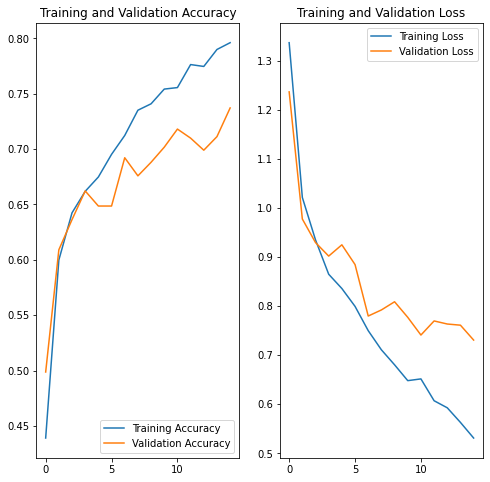

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and Dropout layers are inactive at inference time.

In [30]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

  8192/117948 [=>............................] - ETA: 0s

122880/117948 [===============================] - 0s 0us/step


This image most likely belongs to sunflowers with a 97.38 percent confidence.
